In [1]:
import torch
import ot
import numpy as np
import matplotlib.pylab as pl
import math
import sklearn
from sklearn import datasets

In [2]:
def make_cube(n_samples,dim):
    n_samples=int(n_samples)
    return np.random.random((n_samples, dim)) * 2 - 1

def make_data(expe,n_samples,dim=2):
    if expe=='uniform':
        xs=make_cube(n_samples,dim)
        xt=make_cube(n_samples,dim)
    elif expe=='two_moons':
        X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05)
        xs = X[y==0,:]
        xt = X[y==1,:]
    elif expe=='gaussians' :
        mu_s=np.zeros(dim)
        cov_s=np.ones(dim)
        cov_s = cov_s * np.eye(dim)
        mu_t=np.zeros(dim)
        cov_t=np.ones(dim)
        cov_t = cov_t * np.eye(dim)
        xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
    return xs,xt

In [3]:
def augment_data(x,m=3,eps=1e-2):
    n,d=x.shape
    x_aug=x
    cov=np.ones(d)
    cov= eps*cov * np.eye(d)
    for i in range(n):
        x_aug=np.concatenate((x_aug,np.random.multivariate_normal(x[i,:], cov, m)))
    return x_aug

In [4]:
n,d=100,2
xs,_=make_data('gaussians',n,d)
_,xt=make_data('two_moons',n,d)

In [5]:
xs_aug=augment_data(xs,m=3,eps=1e-1)
xt_aug=augment_data(xt,m=3,eps=1e-2)

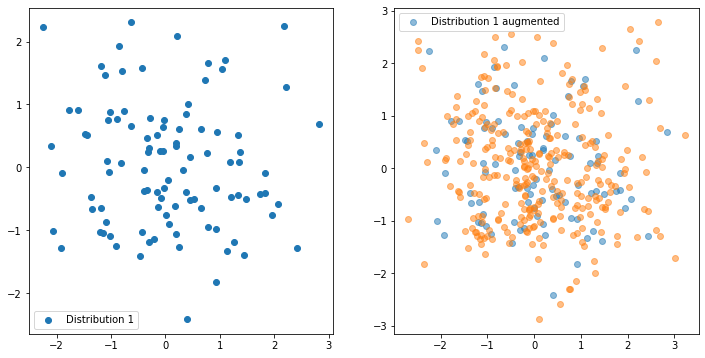

In [6]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
pl.scatter(xs[:, 0], xs[:, 1],alpha=1,label='Distribution 1')
pl.legend()

pl.subplot(1,2,2)
pl.scatter(xs_aug[:n, 0], xs_aug[:n, 1],alpha=.5,label='Distribution 1 augmented')
pl.scatter(xs_aug[n:, 0], xs_aug[n:, 1],alpha=.5,label='')
pl.legend()

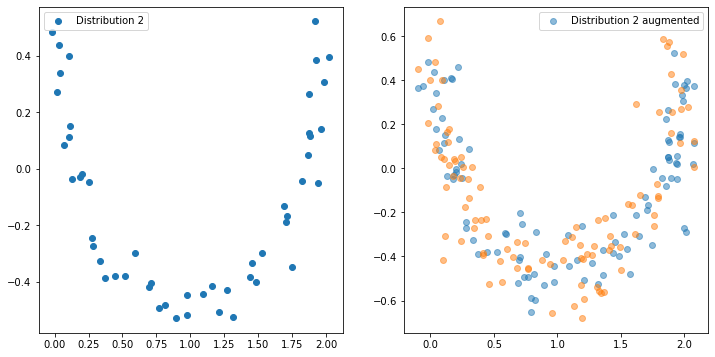

In [7]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
pl.scatter(xt[:, 0], xt[:, 1],alpha=1,label='Distribution 2')
pl.legend()

pl.subplot(1,2,2)
pl.scatter(xt_aug[:n, 0], xt_aug[:n, 1],alpha=.5,label='Distribution 2 augmented')
pl.scatter(xt_aug[n:, 0], xt_aug[n:, 1],alpha=.5,label='')
pl.legend()

In [8]:
def coefflog_approx(x,y):
    x=np.array([math.log10(s) for s in x])
    y=np.array([math.log10(s) for s in y])
    A = np.vstack([x, np.ones(x.shape[0])]).T
    y = y[:, np.newaxis]
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha[0]

# Sample Complexity pour data augmented

In [9]:
n_seed=1 #nb of repetition of the experience

max_n=2
nb_n=20
n_l= np.logspace(1, max_n, nb_n, dtype=int)
print('nb point',n_l)

nb_dim=5
max_dim=2.1#10^
dim_l = np.logspace(.4, max_dim, nb_dim, dtype=int)
print('dim',dim_l)

res=np.zeros((n_seed,len(dim_l),len(n_l)))

nb point [ 10  11  12  14  16  18  20  23  26  29  33  37  42  48  54  61  69  78
  88 100]
dim [  2   6  17  47 125]


In [10]:
for s in range(n_seed):
    print('seed #',s,': ',end=' ')
    for i,d in enumerate(dim_l):
        print(i,end=' ')
        for j,n in enumerate(n_l):
            xs,xt=make_data('gaussians',n,d)
            xs_aug=augment_data(xs,m=8,eps=1e-1)
            xt_aug=augment_data(xt,m=8,eps=1e-1)
            res[s,i,j]=ot.emd2([],[],ot.dist(xs_aug,xt_aug))
    print()

seed # 0 :  0 1 2 3 4 


In [ ]:
res_mean=np.mean(res,axis=0)
res_std = np.std(res, axis=0)

pl.figure(figsize=(12,6))
for i in range(len(dim_l)):
    pl.plot(n_l, res_mean[i,:],c='C%i'%i,label="d = %i"%dim_l[i])
    #pl.fill_between(n_l, res_mean[i,:] -  res_std[i,:], res_mean[i,:] + res_std[i,:], alpha=0.2)
pl.xscale('log')
pl.yscale('log')
pl.xlabel("Number of points")
pl.ylabel("Wasserstein distance")
pl.legend(prop={'size': 20},loc='center right')
pl.title("Sample Complexity for different dimension")

pl.show()

In [ ]:
def coefflog_approx(x,y):
    x=np.array([math.log10(s) for s in x])
    y=np.array([math.log10(s) for s in y])
    A = np.vstack([x, np.ones(x.shape[0])]).T
    y = y[:, np.newaxis]
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha[0]

In [ ]:
coeff_W=np.array([coefflog_approx(n_l,res_mean[i,:])[0] for i in range(nb_dim)])

print("Empirically",coeff_W)
print("Theoretically",-2/dim_l)
print("Theoretically",-1/dim_l)